In [50]:
import pandas as pd
import numpy as np
import os
import json
import joblib

## 1 - Load the training data

In [2]:
file_path = os.path.join('..', 'data', 'cleaned')

train_df = pd.read_csv(os.path.join(file_path, 'train.csv'), low_memory=False)
train_df.head()

,file,VMONTH,VYEAR,VDAYR,YEAR,AGE,SEX,ETHNIC,RACE,USETOBAC,...,PHYSASST,NPNMW,RNLPN,OTHPROV,MHP,NODISP,REFOTHMD,RETAPPT,OTHDISP,ERADMHOS
0,opd2006.csv,December,2006.0,Friday,2006.0,55.0,Male,Not Hispanic or Latino,White Only,Not current,...,No,No,No,No,NaN,One or more dispositions marked,No,No,No,No
1,opd2006.csv,November,2006.0,Thursday,2006.0,66.0,Male,Not Hispanic or Latino,White Only,Not current,...,No,No,No,No,NaN,One or more dispositions marked,No,No,No,No
2,opd2006.csv,November,2006.0,Wednesday,2006.0,71.0,Female,Not Hispanic or Latino,White Only,Not current,...,No,No,No,No,NaN,One or more dispositions marked,Yes,No,No,No
3,opd2006.csv,November,2006.0,Tuesday,2006.0,1.0,Female,Not Hispanic or Latino,White Only,Not current,...,No,No,No,No,NaN,One or more dispositions marked,No,No,No,No
4,opd2006.csv,November,2006.0,Monday,2006.0,21.0,Female,Not Hispanic or Latino,White Only,Current,...,No,No,No,No,NaN,One or more dispositions marked,No,No,No,No


## 2 - Load the vairiables dictionary and define features for clustering

In [3]:
# Load the variables dictionary
with open(os.path.join(file_path, 'variables.json'), 'r') as f:
    variables = json.load(f)

print(f'Variable Categories:\n')
for category, list in variables.items():
    print(f'{category}')
    print(f'{list}')

Variable Categories:

dateOfVisit
['VMONTH', 'VYEAR', 'VDAYR', 'YEAR']
demographics
['AGE', 'SEX', 'ETHNIC', 'RACE', 'USETOBAC']
payment
['PAYPRIV', 'PAYMCARE', 'PAYMCAID', 'PAYWKCMP', 'PAYSELF', 'PAYNOCHG', 'PAYOTH', 'PAYDK', 'PAYTYPER']
visitReason
['INJDET', 'INJURY', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
patientClinicHistory
['SENBEFOR', 'PASTVIS']
vitalSigns
['HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
imputedFields
['BDATEFL', 'SEXFL', 'SENBEFL', 'PASTFL']
physicianDiagnoses
['DIAG1', 'DIAG2', 'DIAG3']
differentialDiagnoses
['PRDIAG1', 'PRDIAG2', 'PRDIAG3']
presentSymptomsStatus
['ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'NOCHRON', 'TOTCHRON', 'DMP']
services
['BREAST', 'PELVIC', 'RECTAL', 'SKIN', 'DEPRESS', 'BONEDENS', 'MAMMO', 'MRI', 'ULTRASND', 'XRAY', 'OTHIMAGE', 'CBC', 'ELECTROL', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA', 'OTHERBLD', 'BIOPSY', 'CHLAMYD', 'PAPCONV', 'PAPLIQ', 'P


### 2.1 Defining features for clustering

##### !!! The statistical test result of the features should be referred first

In [4]:
train_df[variables['visitReason']].value_counts()

INJDET                          INJURY  MAJOR                                 RFV1                               RFV2                                     RFV3                                    
None of the above               No      Chronic problem, routine              Progress visit, NOS                Psychotherapy                            Medication, other and unspecified kinds     43
                                                                              Diabetes mellitus                  Hypertension                             Other endocrine, nutritional, and met...    29
Unintentional injury/poisoning  Yes     Chronic problem, routine              Alcoholism                         Progress visit, NOS                      Psychotherapy                               25
None of the above               No      Chronic problem, routine              Progress visit, NOS                Psychotherapy                            Group counseling                            23
 

In [5]:
# Defining the independent variables as features for clustering
features = \
    ['AGE', 'SEX'] + variables['visitReason'] + ['PASTVIS'] + variables['vitalSigns'] \
    + [item for item in variables['presentSymptomsStatus'] if item not in ['NOCHRON', 'TOTCHRON']]

print(f'Features: {features}')
print(f'Number of Features: {len(features)}')

Features: ['AGE', 'SEX', 'INJDET', 'INJURY', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'DMP']
Number of Features: 31


In [6]:
clustering_df = train_df.loc[:, features]

## 3 - Preprocess and engineer the features

### 3.1 - Bin/Normalize quantitative features
Need to try out results with Binning

In [7]:
from sklearn.preprocessing import StandardScaler

#### 3.1.1 - Binning

#### 3.1.2 - Normalization

In [8]:
# Get a list of quantitative features
quantitative_features = [feature for feature in features if clustering_df[feature].dtype != 'object']

# Normalize quantitative features
scaler = StandardScaler()
clustering_df[quantitative_features] = scaler.fit_transform(clustering_df[quantitative_features])

# Check the result
clustering_df[quantitative_features].head()

,AGE,PASTVIS,HTIN,WTLB,BMI,TEMPF,BPSYS,BPDIAS
0,0.710117,-0.016688,0.530558,1.762024,1.904835,-0.230443,1.800628,1.390837
1,1.177478,-0.389377,0.609827,0.586196,0.243487,-0.533710,-0.678966,-0.880536
2,1.389914,0.281463,-0.103596,0.329405,0.924274,-1.342420,1.304709,-0.231572
3,-1.584197,-0.389377,-1.926787,-1.670855,NaN,0.881535,NaN,NaN
4,-0.734451,0.281463,0.372019,-0.035507,-0.310296,-0.230443,-0.678966,-1.042777


### 3.2 - Dimensionality reduction for quantitative features

### 3.3 - Encode categorical features

In [9]:
# Get a list of categorical features
categorical_features = [feature for feature in features if feature not in quantitative_features]

# One-hot encode categorical features
clustering_df = pd.get_dummies(clustering_df, columns=categorical_features, drop_first=True)

# Get the list of encoded features
encoded_features = [feature for feature in clustering_df.columns if feature not in quantitative_features + categorical_features]

# Check the result
clustering_df[encoded_features].head()

,SEX_Male,INJDET_Adverse effect of med care/surg care/medicinal drug,INJDET_Injury/poisoning - unknown intent,INJDET_Intentional injury/poisoning,INJDET_None of the above,INJDET_Unintentional injury/poisoning,INJURY_Yes,"MAJOR_Chronic problem, flare-up","MAJOR_Chronic problem, routine",MAJOR_New problem (less than 3 mos. onset),...,DEPRN_Yes,DIABETES_Yes,HYPLIPID_Yes,HTN_Yes,IHD_Yes,OBESITY_Yes,OSTPRSIS_Yes,DMP_Not applicable,DMP_Not enrolled,DMP_Ordered/advised to enroll at this visit
0,True,False,False,False,False,True,True,False,False,False,...,False,True,True,False,False,True,False,False,False,False
1,True,False,False,False,True,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,True,True,True,False,True,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False


### 3.4 - Dimensionality reduction for categorical features

### 3.5 - Redefine the clusterring DataFrame for training

In [10]:
# Redefine the clustering DataFrame
clustering_df = clustering_df.loc[:, quantitative_features + encoded_features]

## 4 - Baseline clustering model

### 4.1 - Train models

#### 4.1.1 - KMeans

In [11]:
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [12]:
random_seed = 42

In [13]:
# Impute the missing quantitative values using KNN
n_neighbors = 5
imputer = KNNImputer(n_neighbors=n_neighbors)

clustering_df_imputed = imputer.fit_transform(clustering_df[quantitative_features])

In [14]:
# Concatenate the imputed quantitative features with the encoded categorical features
clustering_df_imputed = pd.concat([
    pd.DataFrame(clustering_df_imputed, columns=quantitative_features), 
    clustering_df[encoded_features]
], axis=1)

In [15]:
# Clustering using KMeans
n_clusters = 10
clustering_model = KMeans(n_clusters=n_clusters, random_state=random_seed)
train_df['cluster'] = clustering_model.fit_predict(clustering_df_imputed)

# Check the result
train_df['cluster'].value_counts()

cluster
5    22533
7    16102
6    12755
1    12475
0     9290
8     9068
9     7240
4     6520
2     4980
3     2523
Name: count, dtype: int64

In [16]:
# Save the clustering model
clustering_model_path = os.path.join('..', 'models')
clustering_model_name = type(clustering_model).__name__

joblib.dump(clustering_model, os.path.join(clustering_model_path, f'{clustering_model_name}.joblib'))

['../models/KMeans.joblib']

### 4.2 - Evaluation of the model

In [17]:
import altair as alt
import vegafusion as vf
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

#### 4.2.1 - Metrics

In [18]:
# Calculate the Silhouette Score
silhouette = silhouette_score(clustering_df_imputed, train_df['cluster'])
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.060936523975194855


In [19]:
# Calculate the sum of squared distances of samples to their closest cluster center
print(f'Sum of Squared Distances: {clustering_model.inertia_}')

Sum of Squared Distances: 617995.8133063597


#### 4.2.2 - Examine cluster centroids

In [20]:
# Check the cluster centers
cluster_centers = pd.DataFrame(clustering_model.cluster_centers_, columns=clustering_df_imputed.columns)

# Inverse transform the cluster centers
cluster_centers[quantitative_features] = scaler.inverse_transform(cluster_centers[quantitative_features])

# Check the result
cluster_centers

,AGE,PASTVIS,HTIN,WTLB,BMI,TEMPF,BPSYS,BPDIAS,SEX_Male,INJDET_Adverse effect of med care/surg care/medicinal drug,...,DEPRN_Yes,DIABETES_Yes,HYPLIPID_Yes,HTN_Yes,IHD_Yes,OBESITY_Yes,OSTPRSIS_Yes,DMP_Not applicable,DMP_Not enrolled,DMP_Ordered/advised to enroll at this visit
0,61.932285,4.606384,65.757950,170.538163,27.714171,97.674985,114.523307,64.730757,0.389601,6.566907e-03,...,0.156529,0.239746,0.198514,0.383895,0.075035,0.063408,0.043923,0.139843,0.186349,0.015072
1,27.161657,3.723956,64.750244,167.186359,27.660375,98.067717,111.619187,66.025775,0.054821,7.213272e-04,...,0.048489,0.040474,0.004969,0.019396,0.000882,0.049291,0.001603,0.774786,0.050974,0.007534
2,3.173092,3.110803,35.302450,32.738916,17.820432,99.294253,103.078153,61.177028,0.533333,2.610442e-03,...,0.004217,0.003614,0.000402,0.002209,0.002209,0.009036,0.000402,0.848795,0.035944,0.002610
3,46.540626,37.039715,65.728339,177.417915,28.460954,97.875997,126.118827,74.620055,0.464923,-2.211772e-17,...,0.308759,0.122077,0.052715,0.191835,0.028537,0.070155,0.014665,0.324217,0.085216,0.004360
4,52.476074,3.065322,66.508497,194.332883,30.772685,97.936666,156.592178,92.716779,0.447546,5.061350e-03,...,0.109202,0.193865,0.158896,0.561810,0.039417,0.105828,0.017485,0.200153,0.184816,0.019479
5,40.084191,2.849365,66.451758,186.220016,29.253656,98.041448,125.358051,78.008140,0.436845,3.905557e-03,...,0.140644,0.051571,0.027960,0.075493,0.004039,0.036082,0.003506,0.586055,0.059427,0.011939
6,17.968169,3.091595,62.023599,119.741090,21.493248,98.027265,110.873697,66.059004,0.430498,3.136025e-03,...,0.092591,0.025951,0.005958,0.015837,0.001333,0.023834,0.000941,0.678871,0.066719,0.007605
7,67.058129,3.838616,65.598895,174.991628,28.534663,97.718200,138.186362,75.363657,0.388026,3.788349e-03,...,0.135387,0.272140,0.229909,0.522171,0.065955,0.056515,0.050677,0.119675,0.163210,0.010247
8,3.050066,2.934715,35.598213,32.252933,17.013549,97.612667,99.243119,59.667005,0.541575,2.315836e-03,...,0.001875,0.003639,0.001213,0.003419,0.001985,0.010476,0.000331,0.835576,0.042347,0.002316
9,45.961464,3.513356,66.155497,271.742514,43.286694,97.944500,129.789503,76.972845,0.337845,4.419890e-03,...,0.151381,0.340193,0.195994,0.469475,0.039917,0.484669,0.011740,0.125552,0.182182,0.026105


#### 4.2.3 - Visualization

## 5 - Extract text features from each cluster

#### 5.1 - Aggregate text data by cluster

In [21]:
for i, (k, v) in zip (range(len(variables)), variables.items()):
    if i < 5:
        print(k, v)

dateOfVisit ['VMONTH', 'VYEAR', 'VDAYR', 'YEAR']
demographics ['AGE', 'SEX', 'ETHNIC', 'RACE', 'USETOBAC']
payment ['PAYPRIV', 'PAYMCARE', 'PAYMCAID', 'PAYWKCMP', 'PAYSELF', 'PAYNOCHG', 'PAYOTH', 'PAYDK', 'PAYTYPER']
visitReason ['INJDET', 'INJURY', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
patientClinicHistory ['SENBEFOR', 'PASTVIS']


In [22]:
for i, (k, v) in zip (range(len(variables)), variables.items()):
    if i >= 5 and i < 10:
        print(k, v)

vitalSigns ['HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
imputedFields ['BDATEFL', 'SEXFL', 'SENBEFL', 'PASTFL']
physicianDiagnoses ['DIAG1', 'DIAG2', 'DIAG3']
differentialDiagnoses ['PRDIAG1', 'PRDIAG2', 'PRDIAG3']
presentSymptomsStatus ['ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'NOCHRON', 'TOTCHRON', 'DMP']


In [23]:
for i, (k, v) in zip (range(len(variables)), variables.items()):
    if i >= 10:
        print(k, v)

services ['BREAST', 'PELVIC', 'RECTAL', 'SKIN', 'DEPRESS', 'BONEDENS', 'MAMMO', 'MRI', 'ULTRASND', 'XRAY', 'OTHIMAGE', 'CBC', 'ELECTROL', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA', 'OTHERBLD', 'BIOPSY', 'CHLAMYD', 'PAPCONV', 'PAPLIQ', 'PAPUNSP', 'HPVDNA', 'EKG', 'SPIRO', 'URINE', 'HTTAKE', 'WTTAKE', 'TEMPTAKE', 'BLODPRES', 'CAM', 'DME', 'HOMEHLTH', 'HOSPICE', 'PT', 'RADTHER', 'SPOCTHER', 'PSYCHOTH', 'OTHMNTL', 'EXCISION', 'ORTHO', 'WOUND', 'ECHOCARD', 'OTHULTRA', 'PROC1', 'PROC2', 'PROC3', 'PROC4', 'PROC5', 'PROC6', 'PROC7', 'PROC8', 'PROC9', 'CATSCAN', 'PREGTEST', 'FOOT', 'RETINAL', 'HIVTEST', 'CAST', 'SPLINT']
healthEducation ['ASTHMAED', 'DIETNUTR', 'EXERCISE', 'GRWTHDEV', 'INJPREV', 'STRESMGT', 'TOBACED', 'WTREDUC', 'OTHLTHED']
medicationsAndImmunizations ['MED1', 'MED2', 'MED3', 'MED4', 'MED5', 'MED6', 'MED7', 'MED8', 'NCMED1', 'NCMED2', 'NCMED3', 'NCMED4', 'NCMED5', 'NCMED6', 'NCMED7', 'NCMED8', 'NUMNEW', 'NUMCONT']
providersSeen ['NOPROVID', 'PHYS', 'PHYSASST', 'NPNMW', 'RNLPN', 'OTHP

In [24]:
train_df.USETOBAC.unique()

array(['Not current', 'Current', nan], dtype=object)

In [25]:
train_df[variables['visitReason']].head()

,INJDET,INJURY,MAJOR,RFV1,RFV2,RFV3
0,Unintentional injury/poisoning,Yes,Acute problem,"Injury, other and unspecified, of sho...",NaN,NaN
1,None of the above,No,Acute problem,Cough,NaN,NaN
2,None of the above,No,Acute problem,General ill feeling,Abnormal eye movements,NaN
3,None of the above,No,Acute problem,Other and unspecified symptoms refera...,NaN,NaN
4,None of the above,No,Acute problem,Throat soreness,Sinus problems,NaN


In [26]:
train_df[variables['vitalSigns']].value_counts()

HTIN  WTLB   BMI    TEMPF  BPSYS  BPDIAS
72.0  165.0  22.38  96.5   130.0  86.0      6
70.0  155.0  22.24  97.1   140.0  88.0      5
64.0  140.0  24.03  97.6   140.0  98.0      4
65.0  132.0  21.96  97.3   140.0  100.0     4
70.0  222.0  31.85  98.4   130.0  88.0      4
                                           ..
63.0  160.0  28.34  97.6   120.0  60.0      1
                    97.5   100.0  60.0      1
                    97.3   130.0  70.0      1
                    97.2   135.0  64.0      1
86.0  279.0  26.52  99.4   155.0  91.0      1
Name: count, Length: 21999, dtype: int64

In [27]:
train_df[variables['physicianDiagnoses']].head()

,DIAG1,DIAG2,DIAG3
0,"Shoulder and upper arm injury, other ...",NaN,NaN
1,"Bronchitis, not specified as acute or...",NaN,NaN
2,Dizziness and giddiness,"Diabetes mellitus w/o complication, t...",Unspecified essential hypertension
3,Unspecified otitis media,Acute upper respiratory infections of...,Chronic rhinitis
4,Unspecified sinusitis (chronic),NaN,NaN


In [28]:
print(train_df.PRDIAG1.unique())
print()

train_df.DIAG1[train_df.PRDIAG1.str.contains('not probable') | (train_df.PRDIAG1 == 'No')].value_counts()

['No' 'Yes' 'Not applicable' 'Dx is not probable, questionable, ruleout'
 'No diagnosis entered' 'Dx is probable, questionable, or ruleout']



DIAG1
Supervision of other normal pregnancy       3754
Routine infant or child health check        3595
Diabetes mellitus w/o complication, t...    3162
Unspecified essential hypertension          2412
Routine gynecological examination           1496
                                            ... 
Unspecified drug dependence, episodic          1
Delayd/secondary postpartm hemorr pos...       1
Ulcer of esophagus without bleeding            1
Closed fracture of other part of hume...       1
Lacrimal fistula                               1
Name: count, Length: 4192, dtype: int64

In [29]:
train_df[variables['presentSymptomsStatus']].value_counts()

ARTHRTIS  ASTHMA  CANCER  CASTAGE   CEBVD  CHF  CRF  COPD  DEPRN  DIABETES  HYPLIPID  HTN  IHD  OBESITY  OSTPRSIS  NOCHRON  TOTCHRON  DMP               
No        No      Yes     Local     No     No   No   No    No     No        No        No   No   No       No        No       1.0       Not enrolled          152
                                                                                                                                      Currently enrolled    150
                          Distant   No     No   No   No    No     No        No        No   No   No       No        No       1.0       Currently enrolled     98
                          Regional  No     No   No   No    No     No        No        No   No   No       No        No       1.0       Currently enrolled     81
                          Distant   No     No   No   No    No     No        No        No   No   No       No        No       1.0       Not enrolled           76
                                               

In [30]:
# Combine `AGE` as Texutal Description
train_df['CombinedText'] = train_df['AGE'].apply(lambda value: '_'.join([str(int(value)), 'year_old']) if pd.notna(value) else '')

# Combine `AGE` as a single description of the patient's age condition
def combine_age(row):
    if pd.notna(row['AGE']):
        if row['AGE'] < 2: return ' '.join([row['CombinedText'], 'Infant'])
        elif row['AGE'] >= 2 and row['AGE'] < 4: return ' '.join([row['CombinedText'], 'Toddler'])
        elif row['AGE'] >= 4 and row['AGE'] < 12: return ' '.join([row['CombinedText'], 'Child'])
        elif row['AGE'] >= 12 and row['AGE'] < 20: return ' '.join([row['CombinedText'], 'Teenager'])
        elif row['AGE'] >= 20 and row['AGE'] < 40: return ' '.join([row['CombinedText'], 'Adult'])
        elif row['AGE'] >= 40 and row['AGE'] < 60: return ' '.join([row['CombinedText'], 'Middle_Aged'])
        elif row['AGE'] >= 60: return ' '.join([row['CombinedText'], 'Senior'])
    else:
        return row['CombinedText']
    

train_df['CombinedText'] = train_df.apply(lambda row: combine_age(row), axis=1)


# Combine `SEX`
train_df['CombinedText'] = train_df[['CombinedText', 'SEX']].apply(lambda row: ' '.join([row.iloc[0], row.iloc[-1]]) if isinstance(row.iloc[-1], str) else row.iloc[0], axis=1)
# Comine `USETOBAC` if the patient is a current tobacco user
train_df['CombinedText'] = train_df[['CombinedText', 'USETOBAC']].apply(lambda row: ' '.join([row.iloc[0], 'TOBACCO user']) if row.iloc[-1] == 'Current' else row.iloc[0], axis=1)

# Combine `visitReason` and rule out the non-relevant reasons
train_df['CombinedText'] = train_df[['CombinedText'] + variables['visitReason'][2:]].apply(
    lambda row: ' '.join([
        val for val in row if isinstance(val, str) and val not in [
            'Problems, complaints, NEC', 'Patient unable to speak English', 'Patient (or spokesperson) refused care', 'Entry of "none" or "no complaint"', 'Inadequate data base', 'Illegible entry'
        ]
    ]), axis=1
)

# Combine `vitalSigns` as Textual Descriptions
# `HTIN`, `WTLB` and `BMI` are combined as a single description of the patient's weight condition.
def combine_bmi(row):
    if pd.notna(row['BMI']):
        if row['BMI'] < 18.5: return ' '.join([row['CombinedText'], 'Underweight'])
        elif row['BMI'] >= 18.5 and row['BMI'] < 25: return ' '.join([row['CombinedText'], 'Normal_weight'])
        elif row['BMI'] >= 25 and row['BMI'] < 30: return ' '.join([row['CombinedText'], 'Overweight'])
        elif row['BMI'] >= 30: return ' '.join([row['CombinedText'], 'Obesity'])
    else:
        return row['CombinedText']


train_df['CombinedText'] = train_df.apply(lambda row: combine_bmi(row), axis=1)


# `TEMPF` are combined as a single description of the patient's temperature condition.
def combine_tempf(row):
    if pd.notna(row['TEMPF']):
        if row['TEMPF'] < 95: return ' '.join([row['CombinedText'], 'Hypothermia'])
        elif row['TEMPF'] >= 95 and row['TEMPF'] < 99: return ' '.join([row['CombinedText'], 'Normal_temperature'])
        elif row['TEMPF'] >= 99 and row['TEMPF'] < 100: return ' '.join([row['CombinedText'], 'Low_grade_fever'])
        elif row['TEMPF'] >= 100 and row['TEMPF'] < 103: return ' '.join([row['CombinedText'], 'Fever'])
        elif row['TEMPF'] >= 103: return ' '.join([row['CombinedText'], 'Hyperpyrexia'])
    else:
        return row['CombinedText']
    

train_df['CombinedText'] = train_df.apply(lambda row: combine_tempf(row), axis=1)


# `BPSYS` are combined as a single description of the patient's blood pressure condition.
def combine_bpsys(row):
    if pd.notna(row['BPSYS']):
        if row['BPSYS'] < 90: return ' '.join([row['CombinedText'], 'Hypotension'])
        elif row['BPSYS'] >= 90 and row['BPSYS'] < 120: return ' '.join([row['CombinedText'], 'Normal_blood_pressure'])
        elif row['BPSYS'] >= 120 and row['BPSYS'] < 140: return ' '.join([row['CombinedText'], 'Prehypertension'])
        elif row['BPSYS'] >= 140: return ' '.join([row['CombinedText'], 'Hypertension'])
    else:
        return row['CombinedText']
    

train_df['CombinedText'] = train_df.apply(lambda row: combine_bpsys(row), axis=1)


# `BPDIAS` are combined as a single description of the patient's blood pressure condition.
def combine_bpdias(row):
    if pd.notna(row['BPDIAS']):
        if row['BPDIAS'] < 60: return ' '.join([row['CombinedText'], 'Low_diastolic_blood_pressure'])
        elif row['BPDIAS'] >= 60 and row['BPDIAS'] < 90: return ' '.join([row['CombinedText'], 'Normal_diastolic_blood_pressure'])
        elif row['BPDIAS'] >= 90 and row['BPDIAS'] < 110: return ' '.join([row['CombinedText'], 'High_diastolic_blood_pressure'])
        elif row['BPDIAS'] >= 110: return ' '.join([row['CombinedText'], 'Hypertension'])
    else:
        return row['CombinedText']
    

train_df['CombinedText'] = train_df.apply(lambda row: combine_bpdias(row), axis=1)


# Convert and combine `presentSymptomsStatus` and rule out 'NO' and 'NONE' symptoms
train_df['CombinedText'] = train_df[['CombinedText', 'ARTHRTIS']].apply(lambda row: ' '.join([row.iloc[0], 'Arthritis']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'ASTHMA']].apply(lambda row: ' '.join([row.iloc[0], 'Asthma']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'CASTAGE', 'CANCER']].apply(
    lambda row: ' '.join([row.iloc[0], row.iloc[1], 'Cancer']) if (row.iloc[-1] == 'Yes') & pd.notna(row.iloc[1])
                                                               else (' '.join([row.iloc[0], 'Cancer']) if row.iloc[-1] == 'Yes' else row.iloc[0]), axis=1
)
train_df['CombinedText'] = train_df[['CombinedText', 'CEBVD']].apply(lambda row: ' '.join([row.iloc[0], 'Cerebrovascular disease']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'CHF']].apply(lambda row: ' '.join([row.iloc[0], 'Congestive heart failure']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'CRF']].apply(lambda row: ' '.join([row.iloc[0], 'Chronic renal failure']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'COPD']].apply(lambda row: ' '.join([row.iloc[0], 'Chronic obstructive pulmonary disease']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'DEPRN']].apply(lambda row: ' '.join([row.iloc[0], 'Depression']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'DIABETES']].apply(lambda row: ' '.join([row.iloc[0], 'Diabetes']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'HYPLIPID']].apply(lambda row: ' '.join([row.iloc[0], 'Hyperlipidemia']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'HTN']].apply(lambda row: ' '.join([row.iloc[0], 'Hypertension']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'IHD']].apply(lambda row: ' '.join([row.iloc[0], 'Ischemic heart disease']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'OBESITY']].apply(lambda row: ' '.join([row.iloc[0], 'Obesity']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'OSTPRSIS']].apply(lambda row: ' '.join([row.iloc[0], 'Osteoporosis']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)
train_df['CombinedText'] = train_df[['CombinedText', 'NOCHRON']].apply(lambda row: ' '.join([row.iloc[0], 'No Chronic Conditions']) if row.iloc[-1] == 'Yes' else row.iloc[0], axis=1)

train_df.loc[train_df.DMP == 'Not enrolled', 'CombinedText'] = train_df.loc[train_df.DMP == 'Not enrolled', 'CombinedText'] + ' Not enrolled in a disease management program'
train_df.loc[train_df.DMP == 'Currently enrolled', 'CombinedText'] = train_df.loc[train_df.DMP == 'Currently enrolled', 'CombinedText'] + ' Currently enrolled in a disease management program'
train_df.loc[train_df.DMP == 'Ordered/advised to enroll at this visit', 'CombinedText'] = train_df.loc[train_df.DMP == 'Ordered/advised to enroll at this visit', 'CombinedText'] \
                                                                                        + ' Ordered/advised to enroll in a disease management program at this visit'

# Combine `physicianDiagnoses` and rule out 'PROBABLE, QUESTIONABLE, OR RULE OUT' diagnoses
train_df['CombinedText'] = train_df[['CombinedText', 'DIAG1', 'PRDIAG1']].apply(
    lambda row: ' '.join([row.iloc[0], row.iloc[1]]) if isinstance(row.iloc[1], str) & (('not probable' not in row.iloc[-1]) | (row.iloc[-1] == 'No'))
                                                        else row.iloc[0], axis=1
)
train_df['CombinedText'] = train_df[['CombinedText', 'DIAG2', 'PRDIAG2']].apply(
    lambda row: ' '.join([row.iloc[0], row.iloc[1]]) if isinstance(row.iloc[1], str) & (('not probable' not in row.iloc[-1]) | (row.iloc[-1] == 'No'))
                                                        else row.iloc[0], axis=1
)
train_df['CombinedText'] = train_df[['CombinedText', 'DIAG3', 'PRDIAG3']].apply(
    lambda row: ' '.join([row.iloc[0], row.iloc[1]]) if isinstance(row.iloc[1], str) & (('not probable' not in row.iloc[-1]) | (row.iloc[-1] == 'No'))
                                                        else row.iloc[0], axis=1
)

train_df.CombinedText.head()

0    55_year_old Middle_Aged Male Acute problem Inj...
1    66_year_old Senior Male Acute problem Cough Ov...
2    71_year_old Senior Female Acute problem Genera...
3    1_year_old Infant Female Acute problem Other a...
4    21_year_old Adult Female TOBACCO user Acute pr...
Name: CombinedText, dtype: object

In [31]:
train_df.CombinedText.notna().sum()

103486

#### 5.2 - Preprocess text data

In [32]:
import spacy
import re

In [33]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(row):
    row = re.sub(r'(\d+),(\d+)', r'\1\2', row)
    row = re.sub(r'(\d+)-(\d+)', r'\1_\2', row)
    doc = nlp(row)
    processed_text = ' '.join(token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct)
    row = re.sub(r'(\d+)_(\d+)', r'\1-\2', row)
    return processed_text

In [34]:
train_df['ProcessedText'] = train_df['CombinedText'].apply(preprocess_text)

In [35]:
train_df.ProcessedText.head()

0    55_year_old middle_age male acute problem inju...
1    66_year_old senior male acute problem cough ov...
2    71_year_old senior female acute problem genera...
3    1_year_old infant female acute problem unspeci...
4    21_year_old adult female tobacco user acute pr...
Name: ProcessedText, dtype: object

In [36]:
# Save the preprocessed DataFrame
processed_file_path = os.path.join('..', 'data', 'processed')
train_df.to_csv(os.path.join(processed_file_path, f'train_{clustering_model_name}.csv'), index=False)

#### 5.3 - Calculate term frequencies

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
# Method 1
# Calculate the TF-IDF for each cluster,
# taking the ProcessedText of each cluster as the documents,
# and the ProcessedText of the entire dataset as the corpus

#clustered_text = train_df.groupby('cluster')['ProcessedText'].apply(lambda row: ' '.join(row)).reset_index()

#vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=5, max_df=0.7)
#tfidf_matrix = vectorizer.fit_transform(clustered_text['ProcessedText'])

#print(tfidf_matrix)

#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
#tfidf_df

In [39]:
# Method 2
# Calculate the TF-IDF of each row within each cluster
# Calculate the average TF-IDF for each cluster

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=5, max_df=0.7)
tfidf_matrix = vectorizer.fit_transform(train_df['ProcessedText'])

# Calculate the average TF-IDF for each cluster
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
cluster_tfidf = pd.concat([train_df['cluster'], tfidf_df], axis=1).groupby('cluster').mean()

cluster_tfidf

,10_year_old,10_year_old child,11_year_old,11_year_old child,12_year_old,12_year_old teenager,13_year_old,13_year_old teenager,14_year_old,14_year_old teenager,...,visit normal_temperature,visit nos,visit obesity,visit specify,vomiting,weakness,weight,weight gain,wound,wrist
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001851,0.020555,0.001117,0.003573,0.000960,0.002719,0.002138,0.000580,0.001574,0.001187
1,0.000492,0.000492,0.000821,0.000821,0.001725,0.001725,0.002217,0.002217,0.003209,0.003209,...,0.000932,0.015548,0.000643,0.001110,0.001639,0.000336,0.001118,0.000788,0.000249,0.000270
2,0.003232,0.003232,0.001219,0.001219,0.000559,0.000559,0.000141,0.000141,0.000165,0.000165,...,0.000242,0.013359,0.000000,0.001347,0.011449,0.000493,0.001605,0.000491,0.000937,0.000584
3,0.003417,0.003417,0.002617,0.002617,0.002112,0.002112,0.002134,0.002134,0.002011,0.002011,...,0.000750,0.031418,0.000478,0.000384,0.000414,0.000956,0.000876,0.000219,0.000651,0.000088
4,0.000039,0.000039,0.000129,0.000129,0.000029,0.000029,0.000101,0.000101,0.000197,0.000197,...,0.001944,0.013128,0.001682,0.004307,0.001709,0.001721,0.001012,0.000792,0.001709,0.001605
5,0.000111,0.000111,0.000259,0.000259,0.000478,0.000478,0.000521,0.000521,0.000960,0.000960,...,0.001855,0.015290,0.001108,0.003002,0.001488,0.001457,0.001262,0.000763,0.002514,0.003032
6,0.017823,0.017823,0.019922,0.019922,0.020102,0.020102,0.020126,0.020126,0.019076,0.019076,...,0.001074,0.019508,0.000062,0.001619,0.003451,0.000850,0.001975,0.001061,0.002175,0.003362
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001330,0.020713,0.001022,0.003574,0.000413,0.002186,0.001178,0.000387,0.001662,0.001080
8,0.002194,0.002194,0.000794,0.000794,0.000175,0.000175,0.000064,0.000064,0.000000,0.000000,...,0.001261,0.014186,0.000000,0.001788,0.007399,0.000499,0.001024,0.000518,0.000702,0.000689


In [40]:
# Punish the weight of '\d+_year_old' by multiplying it by 0.5, using the regex pattern

#tfidf_df = tfidf_df.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)
#cluster_tfidf = cluster_tfidf.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)

#cluster_tfidf

#### 5.4 - Generate word clouds for each cluster

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

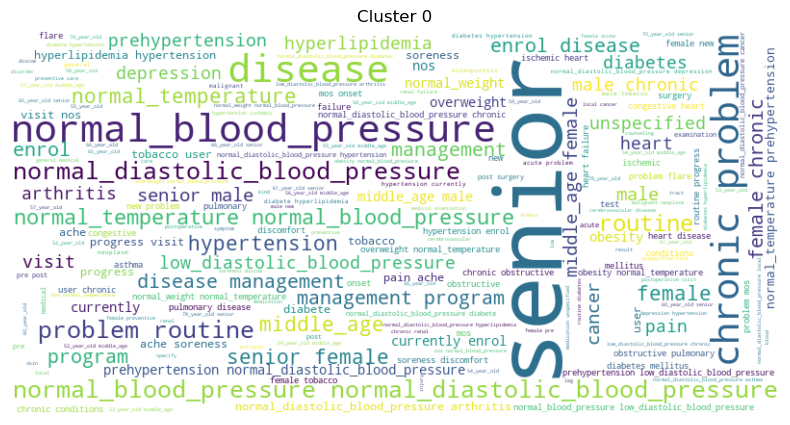

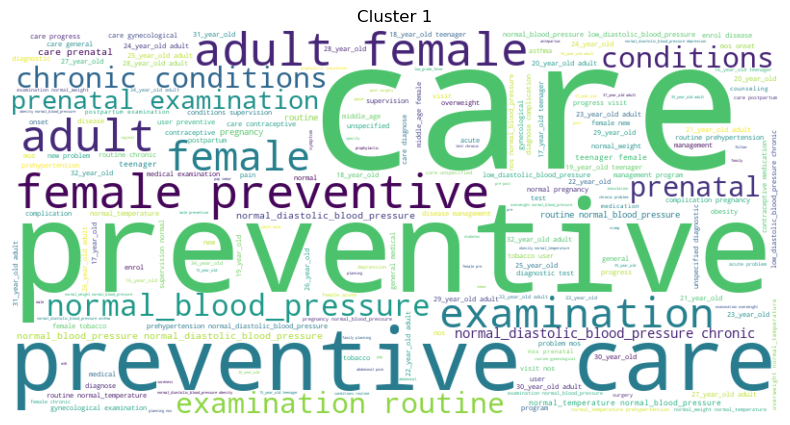

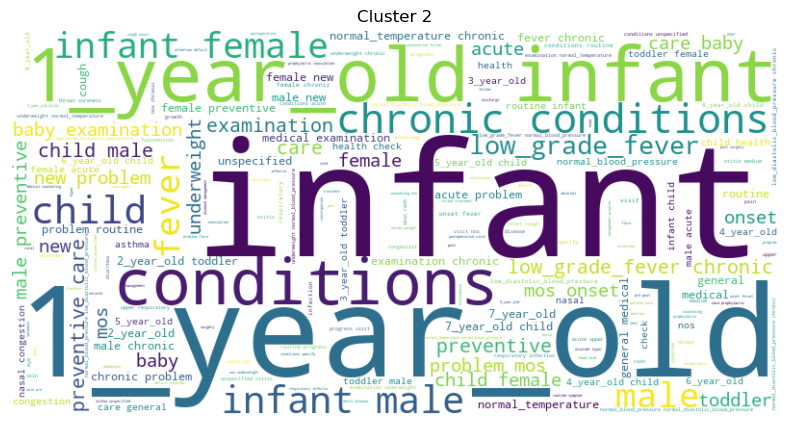

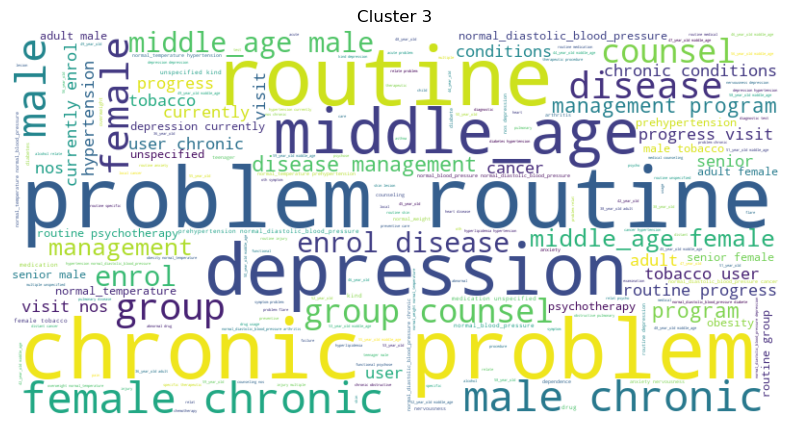

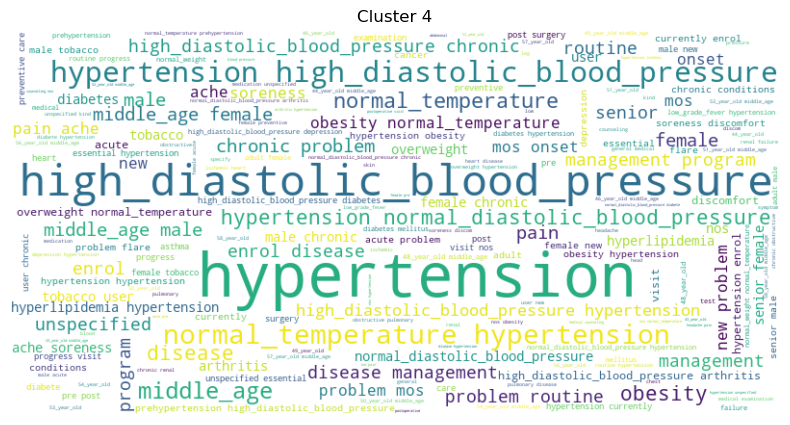

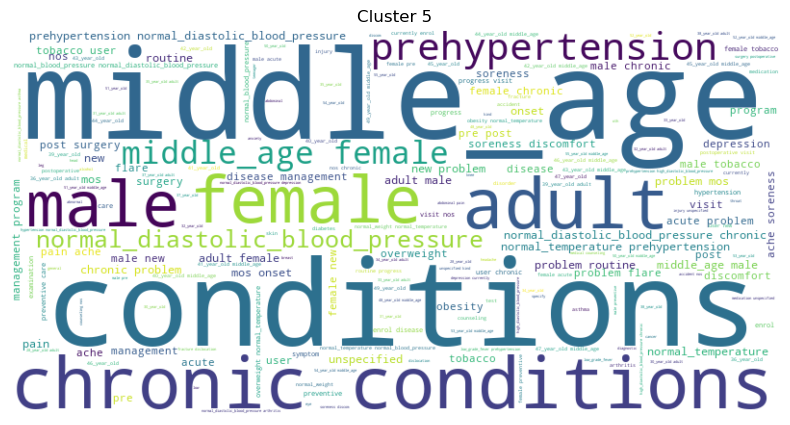

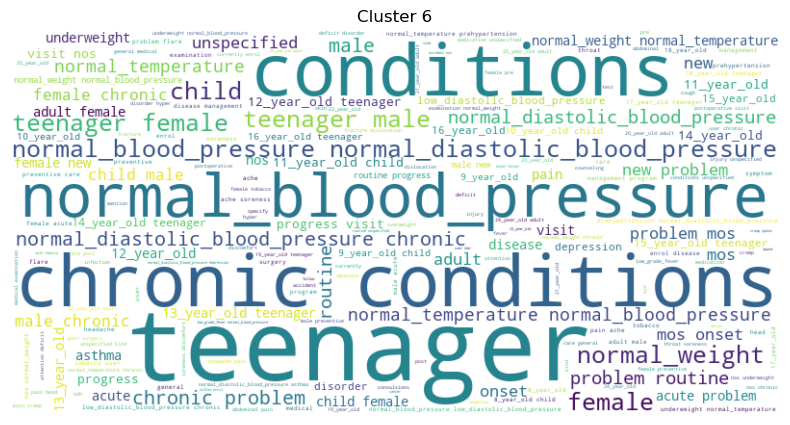

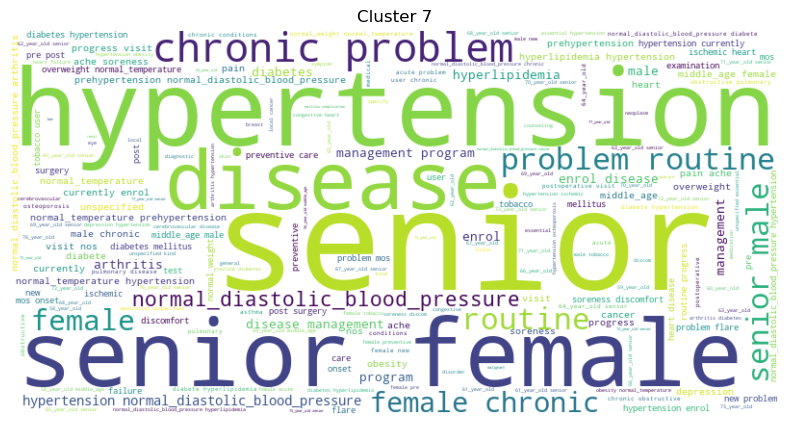

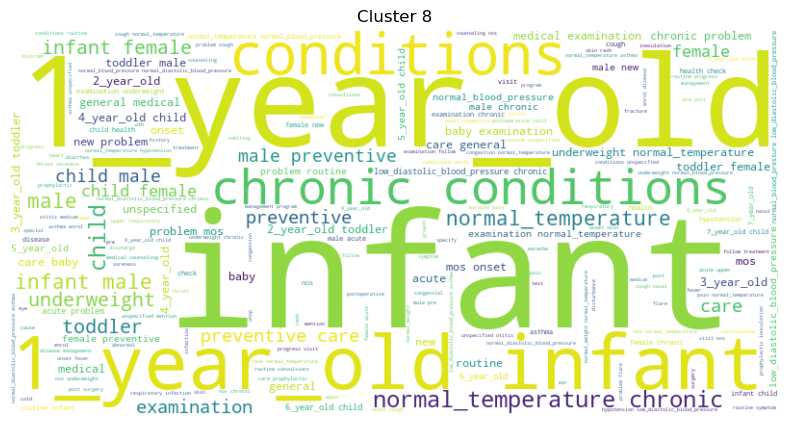

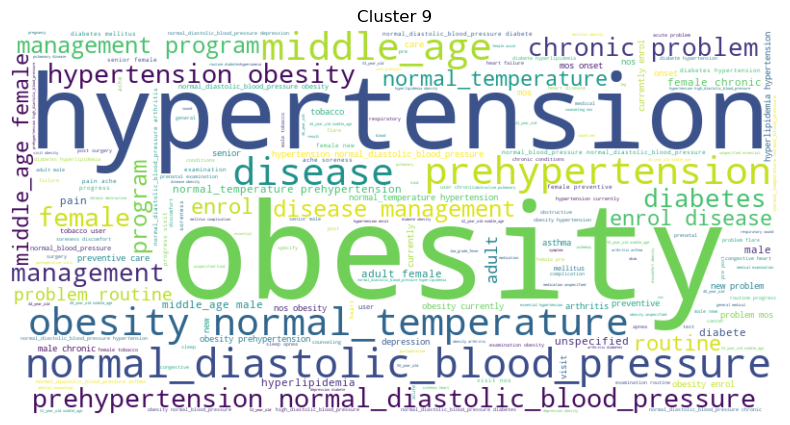

In [42]:
# Plot the word cloud for each cluster basd on the average TF-IDF
for i in range(n_clusters):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(cluster_tfidf.loc[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {i}')
    plt.show()

## 6 - Topic modeling

In [43]:
import gensim
from gensim import corpora

random_seed = 42

In [44]:
# Generate bigrams
def generate_bigrams(row):
    tokens = row.split()
    bigram_model = gensim.models.Phrases(tokens, min_count=5, threshold=100)
    tokens = [token for token in bigram_model[tokens]]
    return tokens


print(generate_bigrams(train_df['ProcessedText'].iloc[0]))
preprocessed_docs = train_df['ProcessedText'].apply(generate_bigrams)

['55_year_old', 'middle_age', 'male', 'acute', 'problem', 'injury', 'unspecified', 'sho', 'obesity', 'normal_temperature', 'hypertension', 'high_diastolic_blood_pressure', 'diabetes', 'hyperlipidemia', 'obesity', 'currently', 'enrol', 'disease', 'management', 'program', 'shoulder', 'upper', 'arm', 'injury']


In [45]:
# Build dictionary and corpus
dictionary = corpora.Dictionary(preprocessed_docs)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

In [46]:
# Train LDA model
n_topics = 10

lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=n_topics,
    random_state=random_seed,
    chunksize=100,
    passes=10,
)



### 6.1 - Visualize the topics

In [47]:
import pyLDAvis.gensim_models
import pyLDAvis

pyLDAvis.enable_notebook()

In [48]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.186274 -0.036205       1        1  19.292874
2      0.190478 -0.127240       2        1  11.549794
6     -0.148710 -0.049779       3        1  11.537603
8      0.089633  0.028992       4        1  10.338626
0      0.033659  0.141387       5        1   9.961427
5      0.233248 -0.063853       6        1   9.876012
1     -0.132458  0.089084       7        1   9.030924
7      0.107829  0.048455       8        1   8.061564
9     -0.143389 -0.229875       9        1   5.242884
4     -0.044016  0.199033      10        1   5.108294, topic_info=                                 Term          Freq         Total Category  \
461                             onset  20936.000000  20936.000000  Default   
1065                                3  20802.000000  20802.000000  Default   
3602                              new  20802.000000  20802.000000  Default   
3601                              mos  20802.000000  20802.000000  Default   
5                             disease  33938.000000  33938.000000  Default   
...                               ...           ...           ...      ...   
92                                leg    944.906963   2782.822638  Topic10   
14                 normal_temperature   1631.786425  43674.158276  Topic10   
9                        hypertension   1338.264928  39838.375706  Topic10   
41                             female   1291.873846  67786.771750  Topic10   
27    normal_diastolic_blood_pressure    949.269007  53135.534065  Topic10   

      logprob  loglift  
461   30.0000  30.0000  
1065  29.0000  29.0000  
3602  28.0000  28.0000  
3601  27.0000  27.0000  
5     26.0000  26.0000  
...       ...      ...  
92    -4.5641   1.8942  
14    -4.0178  -0.3128  
9     -4.2161  -0.4192  
41    -4.2513  -0.9860  
27    -4.5595  -1.0506  

[597 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
264       6  0.998779  10_year_old
642       5  0.112963  12_year_old
642       6  0.092846  12_year_old
642       8  0.793063  12_year_old
617       8  0.999269  13_year_old
...     ...       ...          ...
209       1  0.919005       weight
209       6  0.080333       weight
350       1  0.997585     wheezing
355       5  0.997928        wrist
2066      2  0.996352   xerography

[779 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 7, 9, 1, 6, 2, 8, 10, 5])

### 6.2 - Get the topic distribution for each cluster

In [51]:
# Get the topic distribution for each document 
def get_avg_topic_distribution(cluster_data, topic_distribution, num_topics):
    cluster_topics = np.zeros((len(cluster_data.index), num_topics))

    # Update the distribution with the actual values
    for i, doc_index in enumerate(cluster_data.index.tolist()):
        for topic, prob in topic_distribution[doc_index]:
            cluster_topics[i, topic] = prob

    avg_topic_dist = np.mean(cluster_topics, axis=0)
    return avg_topic_dist


topic_distribution = lda_model.get_document_topics(corpus, minimum_probability=0.0)
clusters = train_df.groupby('cluster').ProcessedText

cluster_topics = []
for cluster, data in clusters:
    avg_topic_dist = get_avg_topic_distribution(data, topic_distribution, lda_model.num_topics)
    cluster_topics.append([avg_topic_dist.tolist()])

cluster_topics_df = pd.DataFrame(cluster_topics, columns=['avg_topic_distribution'])

cluster_topics_df

,avg_topic_distribution
0,"[0.08253554288085863, 0.10246336612260457, 0.0..."
1,"[0.04691510650280766, 0.026346009776317226, 0...."
2,"[0.05133592387012404, 0.02253294932851418, 0.0..."
3,"[0.2839043544432989, 0.05620366420590932, 0.10..."
4,"[0.07191343906987602, 0.12806559798059175, 0.0..."
5,"[0.1669969961232193, 0.11531693680787525, 0.11..."
6,"[0.15663723904330623, 0.05482788219453233, 0.0..."
7,"[0.08094438119042319, 0.11351647213651261, 0.0..."
8,"[0.04525063587256092, 0.021349447442358956, 0...."
9,"[0.09044257690930657, 0.0872583793463682, 0.11..."


### 6.3 - Visualize the distribution of topics within each cluster

In [52]:
import altair as alt

In [53]:
# Reshape the dataframe to have a row for each cluster and topic
cluster_topics_heatmap_df = cluster_topics_df.avg_topic_distribution.apply(pd.Series).reset_index().rename(columns={'index': 'cluster'}).melt(id_vars='cluster', var_name='topic', value_name='probability')

heatmap = alt.Chart(cluster_topics_heatmap_df).mark_rect().encode(
    x='topic:O',
    y='cluster:O',
    color='probability:Q'
).properties(
    title='Average Topic Distribution for Each Cluster',
    width=400,
    height=400
)

heatmap

alt.Chart(...)